In [1]:
PATH = '../data/query_test.csv'
X_MIN = -40.98
X_MAX = -12.983
Y_MIN = -79.805
Y_MAX = -62.402

Import

In [2]:
import pandas as pd

query = pd.read_csv(PATH)
query.head(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-09-13T12:52:26.803Z,-24.1558,-66.8587,174.236,4.5,mb,94,54,1.704,1.26,...,2025-09-13T13:10:30.040Z,"55 km W of San Antonio de los Cobres, Argentina",earthquake,7.15,6.105,0.057,92,reviewed,us,us
1,2025-09-13T11:49:36.358Z,-17.6904,-65.8984,10.000,4.6,mb,25,87,1.943,0.90,...,2025-09-13T14:28:23.040Z,"11 km SSE of Cliza, Bolivia",earthquake,7.19,1.933,0.136,18,reviewed,us,us
2,2025-09-13T11:16:57.749Z,-24.1806,-67.0700,179.787,4.0,mb,67,63,1.591,0.98,...,2025-09-13T12:21:44.040Z,"76 km W of San Antonio de los Cobres, Argentina",earthquake,8.38,4.679,0.081,41,reviewed,us,us


filter

In [3]:
query['time'] = pd.to_numeric(pd.to_datetime(query["time"]))[0] / 10**9 # ns to s
query = query[['longitude', 'latitude', 'depth', 'time', 'mag']]
query.columns = ['x', 'y', 'z', 't', 'm']
query

,x,y,z,t,m
0,-66.8587,-24.1558,174.236,1.757768e+09,4.5
1,-65.8984,-17.6904,10.000,1.757768e+09,4.6
2,-67.0700,-24.1806,179.787,1.757768e+09,4.0
3,-67.0219,-24.2635,186.192,1.757768e+09,4.5
4,-67.1512,-23.9994,188.646,1.757768e+09,4.6
5,-66.6606,-22.9400,222.200,1.757768e+09,4.5
6,-69.3557,-17.8718,158.015,1.757768e+09,4.4
7,-68.5493,-21.5741,136.006,1.757768e+09,4.0
8,-66.7833,-19.4590,259.049,1.757768e+09,4.3
9,-67.1608,-24.3117,169.452,1.757768e+09,4.5


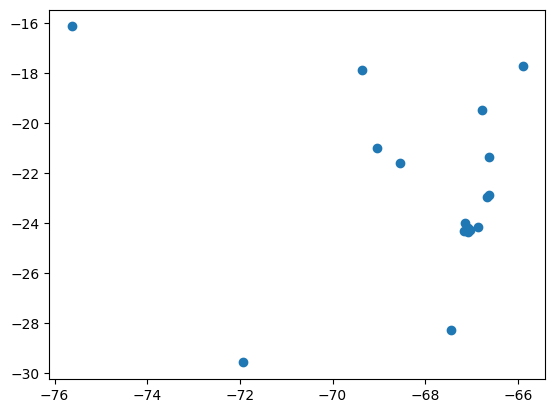

In [4]:
import matplotlib.pyplot as plt
plt.scatter(query['x'], query['y'])

circular mask

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_dataset_2d(dataset,
                    x_idx: int = 0,
                    y_idx: int = 1,
                    figsize: tuple = (8, 6),
                    relative: bool = False,
                    show_reference: bool = True,
                    show_target_point: bool = True,
                    shift_by_first: bool = True,
                    title: str = "Dataset 2D Visualization",
                    max_legend: int = 10):
    """
    Robust 2D plot for datasets where each sample is {'input': tensor_or_array, 'target': tensor_or_array_or_scalar}.
    - If target has same feature-dim as input -> it will be stacked and plotted as part of the sequence.
    - If target is scalar / different-dim -> it will be treated as a label and printed/annotated instead.
    - If relative=True, sequence values are treated as displacements and cumsum is used to get positions.
    - If shift_by_first=True, the function will add the first point's coordinates to every subsequent point
      (vectorized equivalent of:
         for i in range(1, len(x_coords)):
             x_coords[i] += x_coords[0]
             y_coords[i] += y_coords[0]
      ).
    """
    def to_np(x):
        if torch.is_tensor(x):
            return x.cpu().numpy()
        return np.asarray(x)

    if len(dataset) == 0:
        print("Dataset is empty!")
        return

    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.cm.Set3(np.linspace(0, 1, max(3, len(dataset))))

    for i, sample in enumerate(dataset):
        inp = to_np(sample['input'])
        tgt = to_np(sample['target'])

        # Normalize input shapes -> (T, D)
        if inp.ndim == 1:
            inp = inp.reshape(1, -1)
        elif inp.ndim > 2:
            raise ValueError(f"input has too many dims: {inp.shape}")

        # Determine if target is coordinate-like (matching input feature dim)
        target_is_coord = False
        if np.isscalar(tgt) or getattr(tgt, 'ndim', 0) == 0:
            target_is_coord = False
        elif tgt.ndim == 1:
            if tgt.shape[0] == inp.shape[1]:
                tgt = tgt.reshape(1, -1)
                target_is_coord = True
            else:
                if inp.shape[1] == 1:
                    tgt = tgt.reshape(-1, 1)
                    target_is_coord = True
                else:
                    target_is_coord = False
        elif tgt.ndim == 2:
            if tgt.shape[1] == inp.shape[1]:
                target_is_coord = True
            else:
                target_is_coord = False
        else:
            target_is_coord = False

        # Build the sequence that will be plotted
        seq = np.vstack([inp, tgt]) if target_is_coord else inp

        # Convert to float for safe in-place ops
        seq = seq.astype(np.float64, copy=False)

        # If relative displacements, integrate
        if relative:
            pos = np.cumsum(seq, axis=0)
        else:
            pos = seq.copy()

        # Optional: add first point to all subsequent points (vectorized)
        if shift_by_first and pos.shape[0] > 1:
            # add the first coordinate to the rest (equivalent to the loop you provided)
            pos[1:, :] += pos[0, :]

        # safety: ensure requested x_idx/y_idx are in bounds
        if pos.shape[1] <= max(x_idx, y_idx):
            raise IndexError(f"Requested x_idx/y_idx ({x_idx},{y_idx}) out of bounds for data with dim {pos.shape[1]}")

        x = pos[:, x_idx]
        y = pos[:, y_idx]
        color = colors[i % len(colors)]

        if len(x) > 1:
            ax.plot(x, y, '-', linewidth=1, alpha=0.8, label=(f'Sample {i+1}' if i < max_legend else ""))
        ax.scatter(x, y, s=20, alpha=0.9, color=color)

        if show_reference:
            ax.scatter(x[0], y[0], s=60, marker='X', edgecolor='k', linewidth=0.8, zorder=10)
        if show_target_point and target_is_coord:
            ax.scatter(x[-1], y[-1], s=80, marker='*', edgecolor='k', linewidth=0.8, zorder=11)

        if not target_is_coord:
            txt = str(tgt) if (np.isscalar(tgt) or getattr(tgt, 'shape', ()) == ()) else np.array2string(tgt, precision=4, separator=',')
            ax.text(x[-1], y[-1], f' {txt}', fontsize=8, verticalalignment='bottom', horizontalalignment='left', alpha=0.8)

    if len(dataset) <= max_legend:
        ax.legend(loc='best', fontsize='small')
    ax.set_title(title)
    ax.set_xlabel(f"dim {x_idx}")
    ax.set_ylabel(f"dim {y_idx}")
    ax.axis('equal')
    plt.tight_layout()

    # quick console summary for first few samples
    for i in range(min(3, len(dataset))):
        s = dataset[i]
        inp_len = len(s['input'])
        print(f"Sample {i+1}: {inp_len} input points. target shape: {np.asarray(s['target']).shape}")

    plt.show()


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_dataset_2d(dataset,
                    x_idx: int = 0,
                    y_idx: int = 1,
                    figsize: tuple = (8, 6),
                    show_target_point: bool = True,
                    shift_by_first: bool = True,
                    title: str = "Dataset 2D Visualization",
                    max_legend: int = 10):
    """
    2D scatter-only plot for datasets where each sample is {'input': tensor_or_array, 'target': tensor_or_array_or_scalar}.
    - Treats input/target as absolute positions.
    - If target has same feature-dim as input -> it will be stacked and plotted as part of the points.
    - If target is scalar / different-dim -> it will be treated as a label and annotated next to the last point.
    - If shift_by_first=True, adds the first point coordinates to every subsequent point (vectorized).
    """
    def to_np(x):
        if torch.is_tensor(x):
            return x.cpu().numpy()
        return np.asarray(x)

    if len(dataset) == 0:
        print("Dataset is empty!")
        return

    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.cm.Set3(np.linspace(0, 1, max(3, len(dataset))))

    for i, sample in enumerate(dataset):
        inp = to_np(sample['input'])
        tgt = to_np(sample['target'])

        # Normalize input shapes -> (T, D)
        if inp.ndim == 1:
            inp = inp.reshape(1, -1)
        elif inp.ndim > 2:
            raise ValueError(f"input has too many dims: {inp.shape}")

        # Determine if target is coordinate-like (matching input feature dim)
        target_is_coord = False
        if np.isscalar(tgt) or getattr(tgt, 'ndim', 0) == 0:
            target_is_coord = False
        elif tgt.ndim == 1:
            if tgt.shape[0] == inp.shape[1]:
                tgt = tgt.reshape(1, -1)
                target_is_coord = True
            else:
                if inp.shape[1] == 1:
                    tgt = tgt.reshape(-1, 1)
                    target_is_coord = True
                else:
                    target_is_coord = False
        elif tgt.ndim == 2:
            target_is_coord = (tgt.shape[1] == inp.shape[1])
        else:
            target_is_coord = False

        seq = np.vstack([inp, tgt]) if target_is_coord else inp
        seq = seq.astype(np.float64, copy=False)

        # Treat as absolute positions
        pos = seq.copy()

        # Optional: add first point to all subsequent points (vectorized)
        if shift_by_first and pos.shape[0] > 1:
            pos[1:, :] += pos[0, :]

        # bounds check for x_idx/y_idx
        if pos.shape[1] <= max(x_idx, y_idx):
            raise IndexError(f"Requested x_idx/y_idx ({x_idx},{y_idx}) out of bounds for data with dim {pos.shape[1]}")

        x = pos[:, x_idx]
        y = pos[:, y_idx]
        color = colors[i % len(colors)]

        # scatter only (no connecting lines)
        ax.scatter(x, y, s=20, alpha=0.9, color=color,
                   label=(f'Sample {i+1}' if i < max_legend else ""))

        # highlight target point if it exists (scatter with different marker)
        if show_target_point and target_is_coord:
            ax.scatter(x[-1], y[-1], s=80, marker='*', edgecolor='k', linewidth=0.8, zorder=11)

        # annotate when target is not coordinate-like
        if not target_is_coord:
            txt = str(tgt) if (np.isscalar(tgt) or getattr(tgt, 'shape', ()) == ()) else np.array2string(tgt, precision=4, separator=',')
            ax.text(x[-1], y[-1], f' {txt}', fontsize=8, verticalalignment='bottom', horizontalalignment='left', alpha=0.8)

    if len(dataset) <= max_legend:
        ax.legend(loc='best', fontsize='small')
    ax.set_title(title)
    ax.set_xlabel(f"dim {x_idx}")
    ax.set_ylabel(f"dim {y_idx}")
    ax.axis('equal')
    plt.tight_layout()

    # quick console summary for first few samples
    for i in range(min(3, len(dataset))):
        s = dataset[i]
        inp_len = len(s['input'])
        print(f"Sample {i+1}: {inp_len} input points. target shape: {np.asarray(s['target']).shape}")

    plt.show()


9
{'input': tensor([[-6.5261e+01, -1.8041e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.5228e+00, -1.4176e+00,  2.5905e+02,  3.2005e+05,  4.3000e+00]],
       dtype=torch.float64), 'target': tensor([-6.3786e-01,  3.5096e-01,  1.0000e+01,  6.2096e+05,  4.6000e+00],
       dtype=torch.float64)}
Sample 1: 2 input points. target shape: (5,)
Sample 2: 11 input points. target shape: (5,)
Sample 3: 2 input points. target shape: (5,)


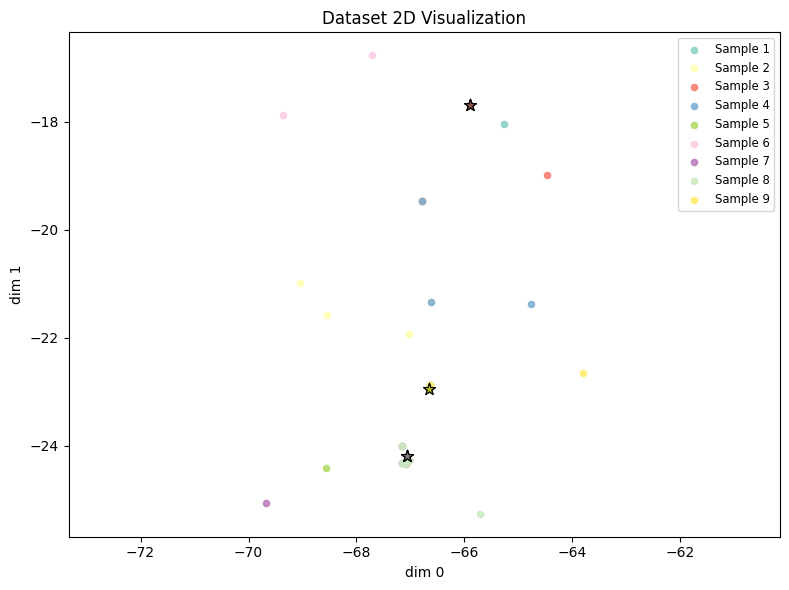

In [32]:
from utils import DatasetSismos, load

dataset = load('../data/query_test_10_300_1.pt')
print(len(dataset))
print(dataset[0])

plot_dataset_2d(dataset)